# Figure. CNV eQTLs

In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_cnv_eqtls'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.m

In [2]:
dy = os.path.join(ciepy.root, 'output/eqtl_processing/eqtls01')
fn = os.path.join(dy, 'lead_variants.tsv')
lead_vars = pd.read_table(fn, index_col=0)
lead_vars = lead_vars[lead_vars.perm_sig]
fn = os.path.join(dy, 'gene_variant_pairs.tsv')
gene_variant = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output/cnv_processing/combined_info.pickle')
combined_info = cPickle.load(open(fn))
combined_info = combined_info[combined_info.emmax]

In [3]:
cnv_lead_vars = lead_vars[lead_vars.variant_type == 'cnv']
cnv_lead_vars['cnv_id'] = cnv_lead_vars.marker_id.apply(lambda x: '_'.join(x.split('_')[2:]))
cnv_gv = gene_variant[gene_variant.variant_type == 'cnv']
cnv_gv['cnv_id'] = cnv_gv.marker_id.apply(lambda x: '_'.join(x.split('_')[2:]))

In [4]:
cnv_gv['cnv_is_lead'] = cnv_gv.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_is_lead'] = lead_vars.gene_id.apply(lambda x: x in cnv_lead_vars.gene_id.values)
lead_vars['cnv_sig'] = lead_vars.gene_id.apply(lambda x: x in cnv_gv.gene_id.values)

In [5]:
lead_vars.sort_values(by='pvalue', inplace=True)
cnv_lead_vars.sort_values(by='pvalue', inplace=True)

In [6]:
gene_bt = pbt.BedTool(cpy.gencode_gene_bed)

In [7]:
s = '\n'.join(combined_info.chrom + '\t' + combined_info.start.astype(str) + 
              '\t' + combined_info.end.astype(str) + '\t' + combined_info.name) + '\n'
cnv_bt = pbt.BedTool(s, from_string=True)
cnv_bt = cnv_bt.sort()

res = cnv_bt.intersect(gene_bt, sorted=True, wo=True)
df = res.to_dataframe()
overlaps_gene = set(df.name)

cnv_gv['cnv_gene'] = cnv_gv.cnv_id + ':' + cnv_gv.gene_id
t = pd.DataFrame(True, index=df.name + ':' + df.thickEnd, columns=['cnv_overlaps_gene'])
cnv_gv = cnv_gv.merge(t, left_on='cnv_gene', right_index=True, how='left')
cnv_gv.ix[cnv_gv.cnv_overlaps_gene.isnull(), 'cnv_overlaps_gene'] = False

cnv_lead_vars['cnv_gene'] = cnv_lead_vars.cnv_id + ':' + cnv_lead_vars.gene_id
cnv_lead_vars = cnv_lead_vars.merge(t, left_on='cnv_gene', right_index=True, how='left')
cnv_lead_vars.ix[cnv_lead_vars.cnv_overlaps_gene.isnull(), 'cnv_overlaps_gene'] = False

I have to reverse the sign of LUMPY deletions because people who are het for a lumpy deletion
have one less copy number than reference and people are homo alt have two less copy number than
reference. All other CNVs are encoded where alts are increasing copy number.

In [82]:
len(set(cnv_lead_vars.cnv_id))

116

In [80]:
cnv_lead_vars.shape

(132, 39)

In [8]:
cnv_lead_vars['svtype'] = combined_info.ix[cnv_lead_vars.cnv_id, 'svtype'].values
ind = cnv_lead_vars[(cnv_lead_vars.variant_caller == 'lumpy') & 
                    (cnv_lead_vars.svtype == 'DEL')].index
cnv_lead_vars.ix[ind, 'beta'] = cnv_lead_vars.ix[ind, 'beta'] * -1

In [9]:
sns.set_style('whitegrid')

In [10]:
cnv_abs_beta_pdf = pd.Series(index=np.arange(0, 3 + 0.1, 0.1))
se = cnv_lead_vars.drop_duplicates('gene_id').beta.abs()
density = stats.gaussian_kde(se)
cnv_abs_beta_pdf = pd.Series(density(cnv_abs_beta_pdf.index), index=cnv_abs_beta_pdf.index)
snv_abs_beta_pdf = pd.DataFrame(index=np.arange(0, 3 + 0.005, 0.005))
se = lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.abs()
density = stats.gaussian_kde(se)
snv_abs_beta_pdf = pd.Series(density(snv_abs_beta_pdf.index), index=snv_abs_beta_pdf.index)

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


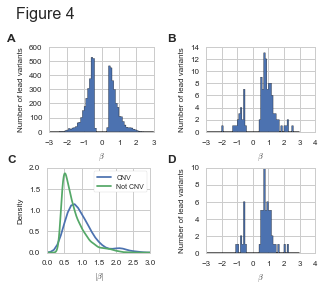

In [11]:
bcolor = (0.29803921568627451, 0.44705882352941179, 0.69019607843137254, 1.0)
bins = np.arange(-3, 3.1, 0.1)

fig = plt.figure(figsize=(4.48, 4), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 0, 'Figure 4',
        size=16, va='bottom')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

# eGenes, no significant CNV.
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of lead variants', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
ax.set_xlim(-3, 3)
gs.tight_layout(fig, rect=[0, 0.42, 0.5, 0.9])

# eGenes with CNV lead variants
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of lead variants', fontsize=8)
gs.tight_layout(fig, rect=[0.5, 0.42, 1, 0.9])

# Absolute value effect size PDFs
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_abs_beta_pdf.plot(label='CNV', ax=ax)
snv_abs_beta_pdf.plot(label='Not CNV', ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\left|\\beta\\right|$', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.legend(fontsize=7, frameon=True, fancybox=True)
gs.tight_layout(fig, rect=[0, 0, 0.5, 0.48])

# Lead variant CNV not overlapping gene
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
g = cnv_lead_vars.ix[cnv_lead_vars.cnv_overlaps_gene, 'gene_id']
t = cnv_lead_vars[cnv_lead_vars.gene_id.apply(lambda x: x not in g.values)]
t.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of lead variants', fontsize=8)
gs.tight_layout(fig, rect=[0.5, 0, 1, 0.48])

t = fig.text(0.005, 0.87, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.87, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.45, 'C', weight='bold', 
             size=12)
t = fig.text(0.5, 0.45, 'D', weight='bold', 
             size=12)

fig.savefig(os.path.join(outdir, 'cnv_eqtls.pdf'))

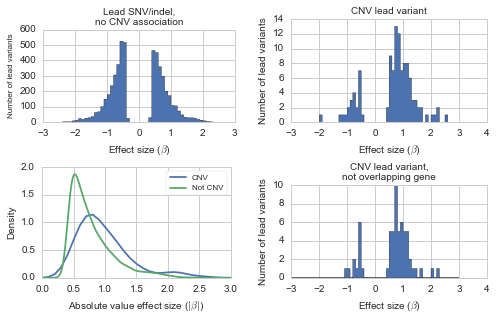

In [83]:
fs = 10

bcolor = (0.29803921568627451, 0.44705882352941179, 0.69019607843137254, 1.0)
bins = np.arange(-3, 3.1, 0.1)

fig = plt.figure(figsize=(7, 4.5), dpi=300)

# eGenes, no significant CNV.
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
lead_vars[lead_vars.cnv_sig == False].drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Effect size ($\\beta$)', fontsize=fs)
ax.set_ylabel('Number of lead variants', fontsize=8)
ax.yaxis.set_major_formatter(ciepy.comma_format)
ax.set_xlim(-3, 3)
ax.set_title('Lead SNV/indel,\nno CNV association', fontsize=fs)
gs.tight_layout(fig, rect=[0, 0.48, 0.5, 1])

# eGenes with CNV lead variants
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Effect size ($\\beta$)', fontsize=fs)
ax.set_ylabel('Number of lead variants', fontsize=fs)
ax.set_title('CNV lead variant', fontsize=fs)
gs.tight_layout(fig, rect=[0.5, 0.48, 1, 1])

# Absolute value effect size PDFs
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
cnv_abs_beta_pdf.plot(label='CNV', ax=ax)
snv_abs_beta_pdf.plot(label='Not CNV', ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Absolute value effect size ($\\left|\\beta\\right|$)', fontsize=fs)
ax.set_ylabel('Density', fontsize=fs)
ax.legend(fontsize=8, frameon=True, fancybox=True)
gs.tight_layout(fig, rect=[0, 0, 0.5, 0.52])

# Lead variant CNV not overlapping gene
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
g = cnv_lead_vars.ix[cnv_lead_vars.cnv_overlaps_gene, 'gene_id']
t = cnv_lead_vars[cnv_lead_vars.gene_id.apply(lambda x: x not in g.values)]
t.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
ax.set_xlabel('Effect size ($\\beta$)', fontsize=fs)
ax.set_ylabel('Number of lead variants', fontsize=fs)
ax.set_title('CNV lead variant,\nnot overlapping gene', fontsize=fs)
gs.tight_layout(fig, rect=[0.5, 0, 1, 0.52])

fig.savefig(os.path.join(outdir, 'cnv_eqtls_presentation.pdf'))

In [37]:
fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'roadmap_res.tsv')
roadmap_res = pd.read_table(fn, index_col=0)

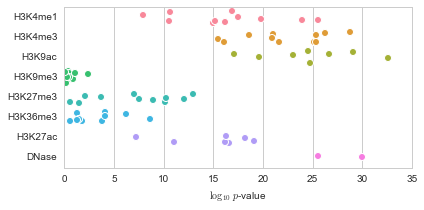

In [56]:
fig,ax = plt.subplots(1, 1, figsize=(6, 3))
sns.stripplot(x='neg_log_pvalue', y='mark', data=roadmap_res, jitter=0.3, 
              ax=ax, orient='h')
for t in ax.get_xticklabels():
    t.set_fontsize(10)
ax.set_xlabel('$\\log_{10}$ $p$-value', fontsize=10)
ax.set_xlim(0, 35)
ax.set_ylabel('');
fig.tight_layout()
fig.savefig(os.path.join(outdir, 'intergenic_enrichment.pdf'))